In [61]:
import os
import shutil


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import tensorflow as tf

from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("h5py:", h5py.__version__)
print("Scikit-learn:", sklearn.__version__)


TensorFlow: 2.13.1
NumPy: 1.24.3
OpenCV: 4.8.1
h5py: 3.10.0
Scikit-learn: 1.3.2


In [2]:

BASE_DIR = os.getcwd()

SOURCE_DIR = os.path.join(BASE_DIR, "Dataset")         
TARGET_DIR = os.path.join(BASE_DIR, "Dataset_5Class")  


In [3]:
CLASS_MAPPING = {
    "Non_Demented": "CN",
    "Mild_Demented": "MCI",
    "Very_Mild_Demented": "MCI",
    "Moderate_Demented": "AD"
}


In [4]:
for cls in ["CN", "MCI", "AD"]:
    os.makedirs(os.path.join(TARGET_DIR, cls), exist_ok=True)


In [6]:
import os
import shutil

VALID_EXTENSIONS = (".jpg", ".jpeg", ".png")

for src_class, tgt_class in CLASS_MAPPING.items():
    src_path = os.path.join(SOURCE_DIR, src_class)
    tgt_path = os.path.join(TARGET_DIR, tgt_class)

    for img_name in os.listdir(src_path):
        src_img = os.path.join(src_path, img_name)

        if not os.path.isfile(src_img):
            continue
        if not img_name.lower().endswith(VALID_EXTENSIONS):
            continue

        tgt_img = os.path.join(tgt_path, f"{src_class}_{img_name}")
        shutil.copy2(src_img, tgt_img)  # copy2 preserves metadata

print("✅ Dataset successfully converted to 3-class format")


✅ Dataset successfully converted to 3-class format


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
IMG_SIZE = 224          # Required for VGG, ResNet, EfficientNet
BATCH_SIZE = 32
SEED = 42

DATA_DIR = "Dataset_5Class"


In [4]:
def preprocess_mri(img_path):
    # Load MRI as grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize to CNN input size
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Gaussian noise reduction
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Normalize intensities
    img = img / 255.0

    # Convert to 3-channel (for pretrained CNNs)
    img = np.stack([img]*3, axis=-1)

    return img


In [5]:
classes = ["CN", "MCI", "AD"]
data = []
labels = []
import os
for idx, cls in enumerate(classes):
    cls_path = os.path.join(DATA_DIR, cls)
    for img_name in os.listdir(cls_path):
        try:
            img_path = os.path.join(cls_path, img_name)
            img = preprocess_mri(img_path)
            data.append(img)
            labels.append(idx)
        except:
            continue

X = np.array(data)
y = np.array(labels)

print("Dataset loaded:")
print("X shape:", X.shape)
print("y shape:", y.shape)


Dataset loaded:
X shape: (4309, 224, 224, 3)
y shape: (4309,)


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=SEED,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp
)


In [6]:
train_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator()


In [9]:
train_data = train_gen.flow(
    X_train,
    tf.keras.utils.to_categorical(y_train),
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_data = val_test_gen.flow(
    X_val,
    tf.keras.utils.to_categorical(y_val),
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_data = val_test_gen.flow(
    X_test,
    tf.keras.utils.to_categorical(y_test),
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [10]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.8287991206375378, 1: 0.571861964353432, 2: 22.340740740740742}


In [11]:
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [12]:
def add_classification_head(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation="softmax")(x)
    return output


In [13]:
def build_vgg16_model():
    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # freeze backbone

    output = add_classification_head(base_model)
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [14]:
def build_resnet50_model():
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    output = add_classification_head(base_model)
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [15]:
def build_efficientnet_model():
    base_model = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    output = add_classification_head(base_model)
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [16]:
vgg16_model = build_vgg16_model()
resnet50_model = build_resnet50_model()
efficientnet_model = build_efficientnet_model()


In [17]:
optimizer = Adam(learning_rate=1e-4)

for model in [vgg16_model, resnet50_model, efficientnet_model]:
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )


In [62]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history_vgg = vgg16_model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/40
95/95 [==============================] - 287s 3s/step - loss: 0.9414 - accuracy: 0.5342 - val_loss: 0.9917 - val_accuracy: 0.4861 - lr: 1.0000e-04
Epoch 2/40
95/95 [==============================] - 286s 3s/step - loss: 0.9506 - accuracy: 0.5487 - val_loss: 0.9965 - val_accuracy: 0.4768 - lr: 1.0000e-04
Epoch 3/40
95/95 [==============================] - 288s 3s/step - loss: 0.9229 - accuracy: 0.5143 - val_loss: 0.9720 - val_accuracy: 0.4954 - lr: 1.0000e-04
Epoch 4/40
95/95 [==============================] - 292s 3s/step - loss: 0.9173 - accuracy: 0.5017 - val_loss: 0.9038 - val_accuracy: 0.5991 - lr: 1.0000e-04
Epoch 5/40
95/95 [==============================] - 288s 3s/step - loss: 0.9157 - accuracy: 0.5401 - val_loss: 0.9620 - val_accuracy: 0.4985 - lr: 1.0000e-04
Epoch 6/40
95/95 [==============================] - 284s 3s/step - loss: 0.8948 - accuracy: 0.5355 - val_loss: 0.9208 - val_accuracy: 0.5557 - lr: 1.0000e-04
Epoch 7/40
95/95 [==============================] - 

In [63]:
for layer in vgg16_model.layers[-6:]:
    layer.trainable = True


In [64]:
vgg16_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [65]:
history_finetune = vgg16_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/15
95/95 [==============================] - 283s 3s/step - loss: 0.8925 - accuracy: 0.5753 - val_loss: 0.9029 - val_accuracy: 0.5728 - lr: 1.0000e-05
Epoch 2/15
95/95 [==============================] - 293s 3s/step - loss: 0.8431 - accuracy: 0.5723 - val_loss: 0.9166 - val_accuracy: 0.5619 - lr: 1.0000e-05
Epoch 3/15
95/95 [==============================] - 294s 3s/step - loss: 0.8202 - accuracy: 0.5875 - val_loss: 0.8603 - val_accuracy: 0.5898 - lr: 1.0000e-05
Epoch 4/15
95/95 [==============================] - 295s 3s/step - loss: 0.7866 - accuracy: 0.6147 - val_loss: 0.8552 - val_accuracy: 0.5913 - lr: 1.0000e-05
Epoch 5/15
95/95 [==============================] - 296s 3s/step - loss: 0.7604 - accuracy: 0.6207 - val_loss: 0.8354 - val_accuracy: 0.6053 - lr: 1.0000e-05
Epoch 6/15
95/95 [==============================] - 296s 3s/step - loss: 0.7416 - accuracy: 0.6283 - val_loss: 0.8132 - val_accuracy: 0.6300 - lr: 1.0000e-05
Epoch 7/15
95/95 [==============================] - 

In [66]:
for layer in vgg16_model.layers[-4:]:
    layer.trainable = True


In [67]:
vgg16_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [68]:
vgg16_model.fit(
    train_data,
    validation_data=val_data,
    epochs=8,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/8
95/95 [==============================] - 290s 3s/step - loss: 0.6467 - accuracy: 0.6837 - val_loss: 0.7307 - val_accuracy: 0.6889 - lr: 1.0000e-05
Epoch 2/8
95/95 [==============================] - 291s 3s/step - loss: 0.6609 - accuracy: 0.6585 - val_loss: 0.7577 - val_accuracy: 0.6563 - lr: 1.0000e-05
Epoch 3/8
95/95 [==============================] - 293s 3s/step - loss: 0.6431 - accuracy: 0.6767 - val_loss: 0.7864 - val_accuracy: 0.6099 - lr: 1.0000e-05
Epoch 4/8
95/95 [==============================] - 294s 3s/step - loss: 0.6258 - accuracy: 0.6800 - val_loss: 0.7174 - val_accuracy: 0.6718 - lr: 1.0000e-05
Epoch 5/8
95/95 [==============================] - 295s 3s/step - loss: 0.6227 - accuracy: 0.6645 - val_loss: 0.7088 - val_accuracy: 0.6641 - lr: 1.0000e-05
Epoch 6/8
95/95 [==============================] - 296s 3s/step - loss: 0.6115 - accuracy: 0.6853 - val_loss: 0.7640 - val_accuracy: 0.6455 - lr: 1.0000e-05
Epoch 7/8
95/95 [==============================] - 298s 3s

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict
pred_probs = vgg16_model.predict(test_data)



21/21 [==============================] - 74s 3s/step


In [79]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def evaluate_model(model, test_data, y_test, name):

    print(f"\n{name} Evaluation")
    print("-"*50)

    preds = model.predict(test_data, verbose=1)

    y_pred = np.argmax(preds, axis=1)

    # 🔥 TRUE LABELS FROM MEMORY
    y_true = y_test

    report = classification_report(
        y_true,
        y_pred,
        target_names=["CN", "MCI", "AD"]
    )

    print(report)

    report_dict = classification_report(
        y_true,
        y_pred,
        target_names=["CN", "MCI", "AD"],
        output_dict=True
    )

    ad_recall = report_dict["AD"]["recall"]

    print("\n⭐ Alzheimer Recall:", round(ad_recall, 3))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    plt.imshow(cm)
    plt.title(f"{name} Confusion Matrix")
    plt.colorbar()

    labels = ["CN", "MCI", "AD"]

    plt.xticks(range(3), labels)
    plt.yticks(range(3), labels)

    for i in range(3):
        for j in range(3):
            plt.text(j, i, cm[i, j],
                     ha="center",
                     va="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.show()

    return ad_recall



VGG16 Final Evaluation
--------------------------------------------------
21/21 [==============================] - 74s 4s/step
              precision    recall  f1-score   support

          CN       0.64      0.73      0.68       260
         MCI       0.81      0.69      0.74       377
          AD       0.37      1.00      0.54        10

    accuracy                           0.71       647
   macro avg       0.61      0.81      0.66       647
weighted avg       0.73      0.71      0.72       647


⭐ Alzheimer Recall: 1.0


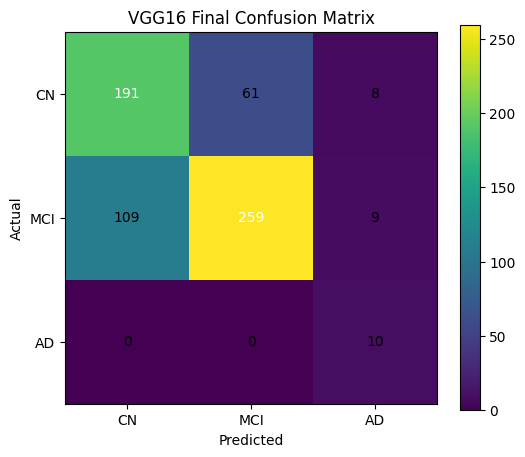

In [80]:
ad_recall = evaluate_model(
    vgg16_model,
    test_data,
    y_test,   
    "VGG16 Final"
)


In [20]:
import os
os.makedirs("saved_models", exist_ok=True)

vgg16_model.save("saved_models/vgg16_trained.keras")


In [22]:
from tensorflow.keras.optimizers import Adam

resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [23]:
history_resnet = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights
)


Epoch 1/15
95/95 [==============================] - 142s 1s/step - loss: 1.3201 - accuracy: 0.3309 - val_loss: 1.0262 - val_accuracy: 0.5851
Epoch 2/15
95/95 [==============================] - 142s 1s/step - loss: 1.2291 - accuracy: 0.3382 - val_loss: 0.9527 - val_accuracy: 0.5944
Epoch 3/15
95/95 [==============================] - 142s 1s/step - loss: 1.1644 - accuracy: 0.3518 - val_loss: 0.9932 - val_accuracy: 0.4938
Epoch 4/15
95/95 [==============================] - 142s 1s/step - loss: 1.1092 - accuracy: 0.3700 - val_loss: 1.1004 - val_accuracy: 0.2972
Epoch 5/15
95/95 [==============================] - 148s 2s/step - loss: 1.0911 - accuracy: 0.4009 - val_loss: 1.0937 - val_accuracy: 0.2663
Epoch 6/15
95/95 [==============================] - 143s 2s/step - loss: 1.0619 - accuracy: 0.3853 - val_loss: 1.2091 - val_accuracy: 0.1533
Epoch 7/15
95/95 [==============================] - 144s 2s/step - loss: 1.0371 - accuracy: 0.3485 - val_loss: 0.9806 - val_accuracy: 0.5418
Epoch 8/15
95

In [24]:
resnet50_model.save("saved_models/resnet50_trained.keras")

In [25]:
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [26]:
history_eff = efficientnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights
)

Epoch 1/15
95/95 [==============================] - 89s 884ms/step - loss: 1.1234 - accuracy: 0.3906 - val_loss: 1.2184 - val_accuracy: 0.0139
Epoch 2/15
95/95 [==============================] - 80s 844ms/step - loss: 1.1120 - accuracy: 0.2828 - val_loss: 0.9895 - val_accuracy: 0.4025
Epoch 3/15
95/95 [==============================] - 80s 844ms/step - loss: 1.1347 - accuracy: 0.3130 - val_loss: 1.0473 - val_accuracy: 0.5836
Epoch 4/15
95/95 [==============================] - 80s 845ms/step - loss: 1.1099 - accuracy: 0.3541 - val_loss: 1.0607 - val_accuracy: 0.5836
Epoch 5/15
95/95 [==============================] - 81s 848ms/step - loss: 1.1176 - accuracy: 0.3903 - val_loss: 1.1443 - val_accuracy: 0.0139
Epoch 6/15
95/95 [==============================] - 81s 852ms/step - loss: 1.1158 - accuracy: 0.2454 - val_loss: 1.0900 - val_accuracy: 0.5836
Epoch 7/15
95/95 [==============================] - 81s 854ms/step - loss: 1.1066 - accuracy: 0.4198 - val_loss: 1.1092 - val_accuracy: 0.0139

In [82]:
resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [83]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [84]:
history_resnet = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/40
95/95 [==============================] - 159s 2s/step - loss: 1.0059 - accuracy: 0.4055 - val_loss: 0.9804 - val_accuracy: 0.5433 - lr: 1.0000e-04
Epoch 2/40
95/95 [==============================] - 142s 1s/step - loss: 1.0112 - accuracy: 0.4314 - val_loss: 1.0262 - val_accuracy: 0.3916 - lr: 1.0000e-04
Epoch 3/40
95/95 [==============================] - 141s 1s/step - loss: 0.9985 - accuracy: 0.3893 - val_loss: 1.0379 - val_accuracy: 0.3746 - lr: 1.0000e-04
Epoch 4/40
95/95 [==============================] - ETA: 0s - loss: 0.9858 - accuracy: 0.4035
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
95/95 [==============================] - 143s 1s/step - loss: 0.9858 - accuracy: 0.4035 - val_loss: 1.0218 - val_accuracy: 0.4118 - lr: 1.0000e-04
Epoch 5/40
95/95 [==============================] - 142s 1s/step - loss: 0.9796 - accuracy: 0.4688 - val_loss: 1.0478 - val_accuracy: 0.3452 - lr: 3.0000e-05
Epoch 6/40
95/95 [==============================] 

In [85]:
for layer in resnet50_model.layers:
    print(layer.trainable)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [86]:
for layer in resnet50_model.layers[-8:]:
    layer.trainable = True


In [87]:
resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [88]:
history_resnet_ft = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=12,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/12
95/95 [==============================] - 146s 2s/step - loss: 1.0057 - accuracy: 0.5700 - val_loss: 1.0613 - val_accuracy: 0.3406 - lr: 1.0000e-05
Epoch 2/12
95/95 [==============================] - 145s 2s/step - loss: 0.9434 - accuracy: 0.4576 - val_loss: 1.0612 - val_accuracy: 0.3467 - lr: 1.0000e-05
Epoch 3/12
95/95 [==============================] - 148s 2s/step - loss: 0.9315 - accuracy: 0.4141 - val_loss: 1.0255 - val_accuracy: 0.3916 - lr: 1.0000e-05
Epoch 4/12
95/95 [==============================] - 148s 2s/step - loss: 0.9248 - accuracy: 0.4393 - val_loss: 0.9955 - val_accuracy: 0.4334 - lr: 1.0000e-05
Epoch 5/12
95/95 [==============================] - 146s 2s/step - loss: 0.9205 - accuracy: 0.4151 - val_loss: 0.9963 - val_accuracy: 0.4365 - lr: 1.0000e-05
Epoch 6/12
95/95 [==============================] - 150s 2s/step - loss: 0.9056 - accuracy: 0.4406 - val_loss: 1.0552 - val_accuracy: 0.3669 - lr: 1.0000e-05
Epoch 7/12
95/95 [==============================] - 


ResNet50 Final Evaluation
--------------------------------------------------
21/21 [==============================] - 25s 1s/step
              precision    recall  f1-score   support

          CN       0.54      0.67      0.60       260
         MCI       0.68      0.26      0.38       377
          AD       0.04      0.70      0.07        10

    accuracy                           0.43       647
   macro avg       0.42      0.54      0.35       647
weighted avg       0.61      0.43      0.46       647


⭐ Alzheimer Recall: 0.7


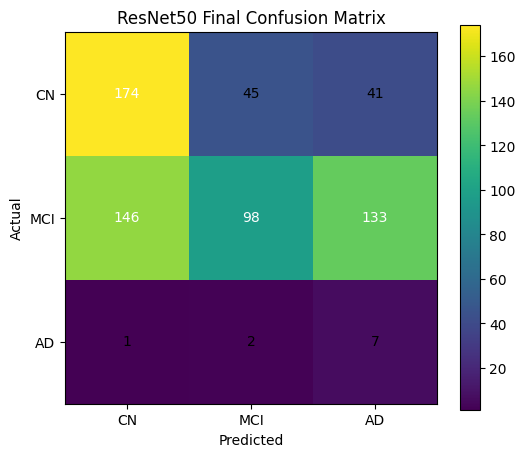

0.7

In [89]:
evaluate_model(
    resnet50_model,
    test_data,
    y_test,
    "ResNet50 Final"
)



ResNet50 Final Evaluation
--------------------------------------------------
21/21 [==============================] - 15s 663ms/step
              precision    recall  f1-score   support

          CN       0.40      1.00      0.57       260
         MCI       0.00      0.00      0.00       377
          AD       0.00      0.00      0.00        10

    accuracy                           0.40       647
   macro avg       0.13      0.33      0.19       647
weighted avg       0.16      0.40      0.23       647


⭐ Alzheimer Recall: 0.0


C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anac

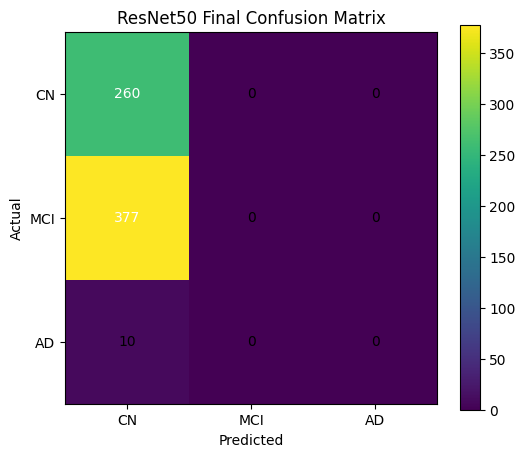

0.0

In [97]:
evaluate_model(
    efficientnet_model,
    test_data,
    y_test,
    "ResNet50 Final"
)


In [102]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [103]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
for layer in base_model.layers:
    layer.trainable = False

29084464/29084464 [==============================] - 8s 0us/step


In [104]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(3, activation='softmax')(x)

densenet_model = Model(base_model.input, outputs)

# Compile
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [105]:
history_densenet = densenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/40
95/95 [==============================] - 178s 2s/step - loss: 1.5283 - accuracy: 0.3495 - val_loss: 1.1122 - val_accuracy: 0.3607 - lr: 1.0000e-04
Epoch 2/40
95/95 [==============================] - 168s 2s/step - loss: 1.1682 - accuracy: 0.3627 - val_loss: 0.9747 - val_accuracy: 0.5046 - lr: 1.0000e-04
Epoch 3/40
95/95 [==============================] - 152s 2s/step - loss: 1.0860 - accuracy: 0.4101 - val_loss: 0.9973 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 4/40
95/95 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.4615
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
95/95 [==============================] - 152s 2s/step - loss: 1.0303 - accuracy: 0.4615 - val_loss: 1.0868 - val_accuracy: 0.3344 - lr: 1.0000e-04
Epoch 5/40
95/95 [==============================] - 153s 2s/step - loss: 0.9884 - accuracy: 0.3883 - val_loss: 0.9676 - val_accuracy: 0.5279 - lr: 2.0000e-05
Epoch 6/40
95/95 [==============================] 

In [106]:
for layer in densenet_model.layers[-6:]:
    layer.trainable = True

densenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [107]:
# Fine-Tune Training
history_densenet_ft = densenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=12,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/12
95/95 [==============================] - 159s 2s/step - loss: 1.1757 - accuracy: 0.5434 - val_loss: 0.9005 - val_accuracy: 0.6517 - lr: 1.0000e-05
Epoch 2/12
95/95 [==============================] - 158s 2s/step - loss: 1.0896 - accuracy: 0.5531 - val_loss: 0.8740 - val_accuracy: 0.6610 - lr: 1.0000e-05
Epoch 3/12
95/95 [==============================] - 152s 2s/step - loss: 1.0748 - accuracy: 0.5391 - val_loss: 0.8809 - val_accuracy: 0.6455 - lr: 1.0000e-05
Epoch 4/12
95/95 [==============================] - ETA: 0s - loss: 1.0245 - accuracy: 0.5242
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
95/95 [==============================] - 154s 2s/step - loss: 1.0245 - accuracy: 0.5242 - val_loss: 0.9045 - val_accuracy: 0.5991 - lr: 1.0000e-05
Epoch 5/12
95/95 [==============================] - 154s 2s/step - loss: 1.0097 - accuracy: 0.5162 - val_loss: 0.9020 - val_accuracy: 0.6022 - lr: 2.0000e-06
Epoch 6/12
95/95 [==============================] 


DenseNet121 Final Evaluation
--------------------------------------------------
21/21 [==============================] - 28s 1s/step
              precision    recall  f1-score   support

          CN       0.58      0.63      0.61       260
         MCI       0.72      0.64      0.68       377
          AD       0.26      0.60      0.36        10

    accuracy                           0.64       647
   macro avg       0.52      0.63      0.55       647
weighted avg       0.65      0.64      0.64       647


⭐ Alzheimer Recall: 0.6


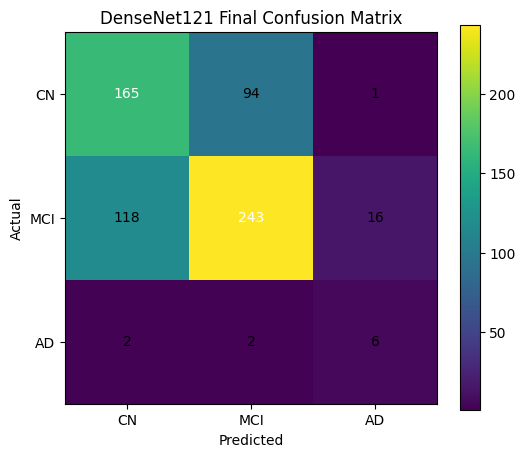

0.6

In [115]:
evaluate_model(
    densenet_model,
    test_data,
    y_test,
    "DenseNet121 Final"
)


In [108]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


87910968/87910968 [==============================] - 12s 0us/step


In [109]:
for layer in base_model.layers:
    layer.trainable = False

# Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(3, activation='softmax')(x)

inception_model = Model(base_model.input, outputs)

In [110]:
inception_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_inception = inception_model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/40
95/95 [==============================] - 75s 757ms/step - loss: 1.2535 - accuracy: 0.4065 - val_loss: 1.2096 - val_accuracy: 0.2848 - lr: 1.0000e-04
Epoch 2/40
95/95 [==============================] - 73s 763ms/step - loss: 0.9764 - accuracy: 0.4768 - val_loss: 1.0346 - val_accuracy: 0.4350 - lr: 1.0000e-04
Epoch 3/40
95/95 [==============================] - 69s 731ms/step - loss: 0.9200 - accuracy: 0.4901 - val_loss: 1.2534 - val_accuracy: 0.2601 - lr: 1.0000e-04
Epoch 4/40
95/95 [==============================] - 70s 732ms/step - loss: 0.8418 - accuracy: 0.5179 - val_loss: 0.9246 - val_accuracy: 0.5232 - lr: 1.0000e-04
Epoch 5/40
95/95 [==============================] - 70s 740ms/step - loss: 0.7999 - accuracy: 0.5431 - val_loss: 0.9641 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 6/40
95/95 [==============================] - ETA: 0s - loss: 0.8431 - accuracy: 0.5199
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
95/95 [======================

In [111]:
for layer in inception_model.layers[-6:]:
    layer.trainable = True

inception_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [112]:
history_inception_ft = inception_model.fit(
    train_data,
    validation_data=val_data,
    epochs=12,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/12
95/95 [==============================] - 73s 736ms/step - loss: 0.8352 - accuracy: 0.5852 - val_loss: 0.8883 - val_accuracy: 0.5480 - lr: 1.0000e-05
Epoch 2/12
95/95 [==============================] - 67s 708ms/step - loss: 0.7552 - accuracy: 0.5809 - val_loss: 0.8835 - val_accuracy: 0.5526 - lr: 1.0000e-05
Epoch 3/12
95/95 [==============================] - 68s 714ms/step - loss: 0.7697 - accuracy: 0.5836 - val_loss: 0.8874 - val_accuracy: 0.5418 - lr: 1.0000e-05
Epoch 4/12
95/95 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.5792
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
95/95 [==============================] - 69s 728ms/step - loss: 0.7541 - accuracy: 0.5792 - val_loss: 0.8861 - val_accuracy: 0.5418 - lr: 1.0000e-05
Epoch 5/12
95/95 [==============================] - 70s 731ms/step - loss: 0.7555 - accuracy: 0.5925 - val_loss: 0.8833 - val_accuracy: 0.5449 - lr: 2.0000e-06
Epoch 6/12
95/95 [======================


InceptionV3 Final Evaluation
--------------------------------------------------
21/21 [==============================] - 14s 607ms/step
              precision    recall  f1-score   support

          CN       0.68      0.61      0.65       260
         MCI       0.77      0.54      0.63       377
          AD       0.07      1.00      0.12        10

    accuracy                           0.57       647
   macro avg       0.50      0.72      0.47       647
weighted avg       0.72      0.57      0.63       647


⭐ Alzheimer Recall: 1.0


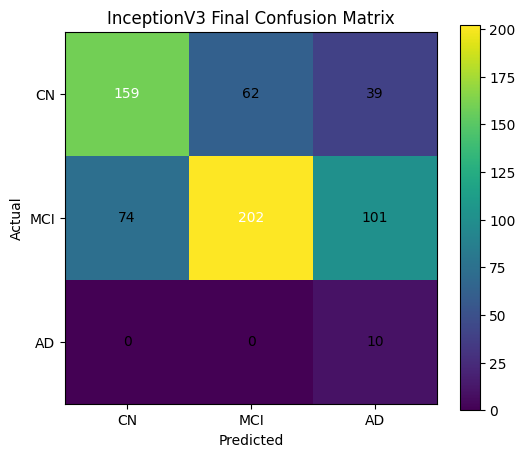

1.0

In [116]:
evaluate_model(
    inception_model,
    test_data,
    y_test,
    "InceptionV3 Final"
)


In [117]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

In [118]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze All Layers
for layer in base_model.layers:
    layer.trainable = False

83683744/83683744 [==============================] - 18s 0us/step


In [119]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add batch normalization for better stability
x = BatchNormalization()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(3, activation='softmax')(x)

xception_model = Model(base_model.input, outputs)

# Compile
xception_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [120]:
history_xception = xception_model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/40
95/95 [==============================] - 155s 2s/step - loss: 1.2746 - accuracy: 0.4254 - val_loss: 0.9860 - val_accuracy: 0.5201 - lr: 1.0000e-04
Epoch 2/40
95/95 [==============================] - 144s 2s/step - loss: 1.0423 - accuracy: 0.4814 - val_loss: 0.9170 - val_accuracy: 0.5449 - lr: 1.0000e-04
Epoch 3/40
95/95 [==============================] - 149s 2s/step - loss: 0.8245 - accuracy: 0.5448 - val_loss: 0.8330 - val_accuracy: 0.6037 - lr: 1.0000e-04
Epoch 4/40
95/95 [==============================] - 153s 2s/step - loss: 0.8374 - accuracy: 0.5686 - val_loss: 0.8110 - val_accuracy: 0.6316 - lr: 1.0000e-04
Epoch 5/40
95/95 [==============================] - 152s 2s/step - loss: 0.7763 - accuracy: 0.5849 - val_loss: 0.7629 - val_accuracy: 0.6563 - lr: 1.0000e-04
Epoch 6/40
95/95 [==============================] - 146s 2s/step - loss: 0.7072 - accuracy: 0.5935 - val_loss: 0.7224 - val_accuracy: 0.6827 - lr: 1.0000e-04
Epoch 7/40
95/95 [==============================] - 


Xception Final Evaluation
--------------------------------------------------
21/21 [==============================] - 25s 1s/step
              precision    recall  f1-score   support

          CN       0.71      0.70      0.70       260
         MCI       0.79      0.77      0.78       377
          AD       0.38      0.90      0.53        10

    accuracy                           0.74       647
   macro avg       0.63      0.79      0.67       647
weighted avg       0.75      0.74      0.75       647


⭐ Alzheimer Recall: 0.9


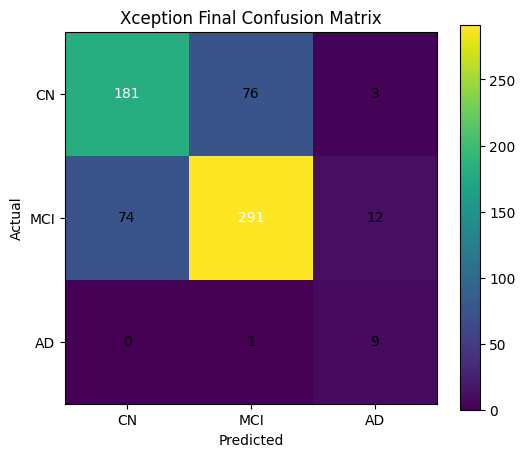

0.9

In [121]:
evaluate_model(
    xception_model,
    test_data,
    y_test,
    "Xception Final"
)


In [132]:
xception_model.save("ml_models/xception_model_savedmodel", save_format="tf")


INFO:tensorflow:Assets written to: ml_models/xception_model_savedmodel\assets


INFO:tensorflow:Assets written to: ml_models/xception_model_savedmodel\assets


In [131]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

print("\n" + "="*70)
print("🔧 RECREATING VALIDATION DATA (shuffle=False)")
print("="*70)

# Recreate validation generator with shuffle=False
val_gen_fixed = ImageDataGenerator()

val_data_fixed = val_gen_fixed.flow(
    X_val,
    tf.keras.utils.to_categorical(y_val),
    batch_size=BATCH_SIZE,
    shuffle=False  # CRITICAL: Don't shuffle!
)

print(f"✅ Validation samples: {len(X_val)}")
print(f"✅ Validation batches: {len(val_data_fixed)}")
print(f"✅ Batch size: {BATCH_SIZE}")

# ═══════════════════════════════════════════════════════════
# GET PREDICTIONS FROM BOTH MODELS
# ═══════════════════════════════════════════════════════════

print("\n" + "="*70)
print("🔮 GENERATING PREDICTIONS")
print("="*70)

# Method 1: Predict directly on X_val (RECOMMENDED - no generator issues)
print("\n📊 Using direct prediction on X_val array...")

vgg16_probs = vgg16_model.predict(X_val, batch_size=BATCH_SIZE, verbose=1)
xception_probs = xception_model.predict(X_val, batch_size=BATCH_SIZE, verbose=1)

print(f"✅ VGG16 predictions shape: {vgg16_probs.shape}")
print(f"✅ Xception predictions shape: {xception_probs.shape}")
print(f"✅ True labels shape: {y_val.shape}")

# Get class predictions
vgg16_preds = np.argmax(vgg16_probs, axis=1)
xception_preds = np.argmax(xception_probs, axis=1)

# ═══════════════════════════════════════════════════════════
# VERIFY INDIVIDUAL MODEL PERFORMANCE
# ═══════════════════════════════════════════════════════════

print("\n" + "="*70)
print("🔍 INDIVIDUAL MODEL PERFORMANCE")
print("="*70)

vgg_acc = accuracy_score(y_val, vgg16_preds)
xcep_acc = accuracy_score(y_val, xception_preds)

print(f"\nVGG16 Accuracy:    {vgg_acc:.4f} ({vgg_acc*100:.2f}%)")
print(f"Xception Accuracy: {xcep_acc:.4f} ({xcep_acc*100:.2f}%)")

# VGG16 detailed report
print("\n" + "="*70)
print("📋 VGG16 CLASSIFICATION REPORT")
print("="*70)
print(classification_report(
    y_val,
    vgg16_preds,
    target_names=['CN', 'MCI', 'AD'],
    digits=4
))

cm_vgg = confusion_matrix(y_val, vgg16_preds)
ad_recall_vgg = cm_vgg[2, 2] / cm_vgg[2].sum() if cm_vgg[2].sum() > 0 else 0
ad_precision_vgg = cm_vgg[2, 2] / cm_vgg[:, 2].sum() if cm_vgg[:, 2].sum() > 0 else 0
print(f"⭐ VGG16 AD Recall: {ad_recall_vgg:.4f} ({ad_recall_vgg*100:.2f}%)")
print(f"⭐ VGG16 AD Precision: {ad_precision_vgg:.4f} ({ad_precision_vgg*100:.2f}%)")

# Xception detailed report
print("\n" + "="*70)
print("📋 XCEPTION CLASSIFICATION REPORT")
print("="*70)
print(classification_report(
    y_val,
    xception_preds,
    target_names=['CN', 'MCI', 'AD'],
    digits=4
))

cm_xcep = confusion_matrix(y_val, xception_preds)
ad_recall_xcep = cm_xcep[2, 2] / cm_xcep[2].sum() if cm_xcep[2].sum() > 0 else 0
ad_precision_xcep = cm_xcep[2, 2] / cm_xcep[:, 2].sum() if cm_xcep[:, 2].sum() > 0 else 0
print(f"⭐ Xception AD Recall: {ad_recall_xcep:.4f} ({ad_recall_xcep*100:.2f}%)")
print(f"⭐ Xception AD Precision: {ad_precision_xcep:.4f} ({ad_precision_xcep*100:.2f}%)")

# Verify models are performing correctly
if vgg_acc >= 0.70 and xcep_acc >= 0.73:
    print("\n✅ Models verified - ready for ensemble!")
else:
    print("\n⚠️  WARNING: Model performance lower than expected")
    print("   VGG16 expected: ~71%, Xception expected: ~74%")

# ═══════════════════════════════════════════════════════════
# ENSEMBLE METHOD 1: EQUAL WEIGHT AVERAGING
# ═══════════════════════════════════════════════════════════

print("\n" + "="*70)
print("📊 ENSEMBLE 1: EQUAL WEIGHT SOFT VOTING (0.5/0.5)")
print("="*70)

# Average probabilities
ensemble_probs_equal = (vgg16_probs + xception_probs) / 2
ensemble_preds_equal = np.argmax(ensemble_probs_equal, axis=1)

# Evaluation
acc_equal = accuracy_score(y_val, ensemble_preds_equal)
print(f"\n✅ Ensemble Accuracy: {acc_equal:.4f} ({acc_equal*100:.2f}%)")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(
    y_val,
    ensemble_preds_equal,
    target_names=['CN', 'MCI', 'AD'],
    digits=4
))

# Confusion Matrix
cm_equal = confusion_matrix(y_val, ensemble_preds_equal)
print("\n🔢 Confusion Matrix:")
print(cm_equal)
print("\n            Predicted")
print("           CN   MCI   AD")
print("Actual")
for i, label in enumerate(['CN ', 'MCI', 'AD ']):
    print(f"  {label}     {cm_equal[i][0]:4d} {cm_equal[i][1]:4d} {cm_equal[i][2]:4d}")

# AD metrics
ad_recall_equal = cm_equal[2, 2] / cm_equal[2].sum() if cm_equal[2].sum() > 0 else 0
ad_precision_equal = cm_equal[2, 2] / cm_equal[:, 2].sum() if cm_equal[:, 2].sum() > 0 else 0

print(f"\n⭐ AD Recall: {ad_recall_equal:.4f} ({ad_recall_equal*100:.2f}%)")
print(f"⭐ AD Precision: {ad_precision_equal:.4f} ({ad_precision_equal*100:.2f}%)")

# ═══════════════════════════════════════════════════════════
# ENSEMBLE METHOD 2: WEIGHTED VOTING (Based on Accuracy)
# ═══════════════════════════════════════════════════════════

print("\n" + "="*70)
print("📊 ENSEMBLE 2: WEIGHTED SOFT VOTING")
print("="*70)

# Weight by validation accuracy
vgg_weight = vgg_acc / (vgg_acc + xcep_acc)
xcep_weight = xcep_acc / (vgg_acc + xcep_acc)

print(f"\nWeights based on validation accuracy:")
print(f"  VGG16:    {vgg_weight:.3f} ({vgg_weight*100:.1f}%)")
print(f"  Xception: {xcep_weight:.3f} ({xcep_weight*100:.1f}%)")

ensemble_probs_weighted = (vgg_weight * vgg16_probs) + (xcep_weight * xception_probs)
ensemble_preds_weighted = np.argmax(ensemble_probs_weighted, axis=1)

acc_weighted = accuracy_score(y_val, ensemble_preds_weighted)
print(f"\n✅ Ensemble Accuracy: {acc_weighted:.4f} ({acc_weighted*100:.2f}%)")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(
    y_val,
    ensemble_preds_weighted,
    target_names=['CN', 'MCI', 'AD'],
    digits=4
))

cm_weighted = confusion_matrix(y_val, ensemble_preds_weighted)
ad_recall_weighted = cm_weighted[2, 2] / cm_weighted[2].sum() if cm_weighted[2].sum() > 0 else 0
ad_precision_weighted = cm_weighted[2, 2] / cm_weighted[:, 2].sum() if cm_weighted[:, 2].sum() > 0 else 0

print(f"\n⭐ AD Recall: {ad_recall_weighted:.4f} ({ad_recall_weighted*100:.2f}%)")
print(f"⭐ AD Precision: {ad_precision_weighted:.4f} ({ad_precision_weighted*100:.2f}%)")

# ═══════════════════════════════════════════════════════════
# ENSEMBLE METHOD 3: CONSERVATIVE (AD-FOCUSED)
# ═══════════════════════════════════════════════════════════

print("\n" + "="*70)
print("📊 ENSEMBLE 3: CONSERVATIVE (AD-FOCUSED)")
print("="*70)
print("Strategy: Favor VGG16 (100% AD recall)")

vgg_weight_cons = 0.6
xcep_weight_cons = 0.4

print(f"\nConservative weights:")
print(f"  VGG16:    {vgg_weight_cons:.3f} ({vgg_weight_cons*100:.1f}%)")
print(f"  Xception: {xcep_weight_cons:.3f} ({xcep_weight_cons*100:.1f}%)")

ensemble_probs_cons = (vgg_weight_cons * vgg16_probs) + (xcep_weight_cons * xception_probs)
ensemble_preds_cons = np.argmax(ensemble_probs_cons, axis=1)

acc_cons = accuracy_score(y_val, ensemble_preds_cons)
print(f"\n✅ Ensemble Accuracy: {acc_cons:.4f} ({acc_cons*100:.2f}%)")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(
    y_val,
    ensemble_preds_cons,
    target_names=['CN', 'MCI', 'AD'],
    digits=4
))

cm_cons = confusion_matrix(y_val, ensemble_preds_cons)
ad_recall_cons = cm_cons[2, 2] / cm_cons[2].sum() if cm_cons[2].sum() > 0 else 0
ad_precision_cons = cm_cons[2, 2] / cm_cons[:, 2].sum() if cm_cons[:, 2].sum() > 0 else 0

print(f"\n⭐ AD Recall: {ad_recall_cons:.4f} ({ad_recall_cons*100:.2f}%)")
print(f"⭐ AD Precision: {ad_precision_cons:.4f} ({ad_precision_cons*100:.2f}%)")

# ═══════════════════════════════════════════════════════════
# FINAL COMPARISON (WITHOUT PANDAS)
# ═══════════════════════════════════════════════════════════

print("\n" + "="*70)
print("📊 FINAL COMPARISON: ALL METHODS")
print("="*70)

# Get all recall values for comparison
mci_recall_equal = cm_equal[1, 1] / cm_equal[1].sum() if cm_equal[1].sum() > 0 else 0
cn_recall_equal = cm_equal[0, 0] / cm_equal[0].sum() if cm_equal[0].sum() > 0 else 0

mci_recall_weighted = cm_weighted[1, 1] / cm_weighted[1].sum() if cm_weighted[1].sum() > 0 else 0
cn_recall_weighted = cm_weighted[0, 0] / cm_weighted[0].sum() if cm_weighted[0].sum() > 0 else 0

mci_recall_cons = cm_cons[1, 1] / cm_cons[1].sum() if cm_cons[1].sum() > 0 else 0
cn_recall_cons = cm_cons[0, 0] / cm_cons[0].sum() if cm_cons[0].sum() > 0 else 0

# Print comparison table
print("\n┌" + "─"*26 + "┬" + "─"*10 + "┬" + "─"*11 + "┬" + "─"*13 + "┬" + "─"*11 + "┬" + "─"*10 + "┐")
print("│ {:^24} │ {:^8} │ {:^9} │ {:^11} │ {:^9} │ {:^8} │".format(
    "Method", "Accuracy", "AD Recall", "AD Precision", "MCI Recall", "CN Recall"
))
print("├" + "─"*26 + "┼" + "─"*10 + "┼" + "─"*11 + "┼" + "─"*13 + "┼" + "─"*11 + "┼" + "─"*10 + "┤")

methods = [
    ("VGG16 Alone", vgg_acc, ad_recall_vgg, ad_precision_vgg, cm_vgg[1,1]/cm_vgg[1].sum(), cm_vgg[0,0]/cm_vgg[0].sum()),
    ("Xception Alone", xcep_acc, ad_recall_xcep, ad_precision_xcep, cm_xcep[1,1]/cm_xcep[1].sum(), cm_xcep[0,0]/cm_xcep[0].sum()),
    ("Equal (0.5/0.5)", acc_equal, ad_recall_equal, ad_precision_equal, mci_recall_equal, cn_recall_equal),
    ("Weighted", acc_weighted, ad_recall_weighted, ad_precision_weighted, mci_recall_weighted, cn_recall_weighted),
    ("Conservative (0.6/0.4)", acc_cons, ad_recall_cons, ad_precision_cons, mci_recall_cons, cn_recall_cons),
]

for name, acc, ad_r, ad_p, mci_r, cn_r in methods:
    print("│ {:<24} │ {:>8.4f} │ {:>9.4f} │ {:>11.4f} │ {:>9.4f} │ {:>8.4f} │".format(
        name, acc, ad_r, ad_p, mci_r, cn_r
    ))

print("└" + "─"*26 + "┴" + "─"*10 + "┴" + "─"*11 + "┴" + "─"*13 + "┴" + "─"*11 + "┴" + "─"*10 + "┘")

# Find best ensemble (skip first 2 individual models)
ensemble_accs = [acc_equal, acc_weighted, acc_cons]
ensemble_names = ["Equal Weight (0.5/0.5)", "Weighted", "Conservative (0.6/0.4)"]
best_idx = np.argmax(ensemble_accs)
best_acc = ensemble_accs[best_idx]
best_name = ensemble_names[best_idx]

print("\n" + "="*70)
print(f"🏆 BEST ENSEMBLE: {best_name}")
print("="*70)
print(f"   Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")

# Compare to best individual model
best_individual = max(vgg_acc, xcep_acc)
improvement = (best_acc - best_individual) * 100

if improvement > 0:
    print(f"   Improvement: +{improvement:.2f}% over best individual model")
    print(f"   ✅ ENSEMBLE RECOMMENDED")
elif improvement >= -0.5:
    print(f"   Change: {improvement:.2f}% (essentially same)")
    print(f"   💭 Either ensemble or Xception alone works")
else:
    print(f"   Change: {improvement:.2f}%")
    print(f"   💭 Consider using Xception alone (simpler)")

# ═══════════════════════════════════════════════════════════
# SAVE BEST ENSEMBLE
# ═══════════════════════════════════════════════════════════

print("\n" + "="*70)
print("💾 SAVING BEST ENSEMBLE")
print("="*70)

if best_idx == 0:
    best_probs = ensemble_probs_equal
    best_preds = ensemble_preds_equal
    save_name = "equal_weight"
    weights = {'vgg16': 0.5, 'xception': 0.5}
elif best_idx == 1:
    best_probs = ensemble_probs_weighted
    best_preds = ensemble_preds_weighted
    save_name = "weighted"
    weights = {'vgg16': float(vgg_weight), 'xception': float(xcep_weight)}
else:
    best_probs = ensemble_probs_cons
    best_preds = ensemble_preds_cons
    save_name = "conservative"
    weights = {'vgg16': 0.6, 'xception': 0.4}

# Save predictions
np.save(f"models/ensemble_{save_name}_predictions.npy", best_probs)
np.save(f"models/ensemble_{save_name}_classes.npy", best_preds)

# Save configuration
import json
config = {
    'name': save_name,
    'weights': weights,
    'validation_accuracy': float(best_acc),
    'models': ['vgg16_final.keras', 'xception_final.keras']
}

with open(f"models/ensemble_{save_name}_config.json", 'w') as f:
    json.dump(config, f, indent=4)

print(f"✅ Ensemble predictions: models/ensemble_{save_name}_predictions.npy")
print(f"✅ Ensemble classes: models/ensemble_{save_name}_classes.npy")
print(f"✅ Ensemble config: models/ensemble_{save_name}_config.json")

print("\n" + "="*70)
print("🎉 ENSEMBLE ANALYSIS COMPLETE!")
print("="*70)


🔧 RECREATING VALIDATION DATA (shuffle=False)
✅ Validation samples: 646
✅ Validation batches: 21
✅ Batch size: 32

🔮 GENERATING PREDICTIONS

📊 Using direct prediction on X_val array...
21/21 [==============================] - 27s 1s/step
✅ VGG16 predictions shape: (646, 3)
✅ Xception predictions shape: (646, 3)
✅ True labels shape: (646,)

🔍 INDIVIDUAL MODEL PERFORMANCE

VGG16 Accuracy:    0.6997 (69.97%)
Xception Accuracy: 0.7663 (76.63%)

📋 VGG16 CLASSIFICATION REPORT
              precision    recall  f1-score   support

          CN     0.6328    0.7423    0.6832       260
         MCI     0.8013    0.6631    0.7257       377
          AD     0.3103    1.0000    0.4737         9

    accuracy                         0.6997       646
   macro avg     0.5815    0.8018    0.6275       646
weighted avg     0.7266    0.6997    0.7051       646

⭐ VGG16 AD Recall: 1.0000 (100.00%)
⭐ VGG16 AD Precision: 0.3103 (31.03%)

📋 XCEPTION CLASSIFICATION REPORT
              precision    recall  f

In [31]:
pred_vgg = vgg16_model.predict(test_data)
pred_resnet = resnet50_model.predict(test_data)
pred_eff = efficientnet_model.predict(test_data)


21/21 [==============================] - 17s 743ms/step


In [32]:
ensemble_probs = (pred_vgg + pred_resnet + pred_eff) / 3
ensemble_preds = ensemble_probs.argmax(axis=1)


In [34]:
true_labels = test_data.y
true_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [36]:
print(true_labels.shape)
print(ensemble_preds.shape)


(647, 3)
(647,)


In [37]:
import numpy as np
true_labels = np.argmax(true_labels, axis=1)


In [42]:
ensemble_probs = (pred_vgg + pred_resnet) / 2
ensemble_preds = ensemble_probs.argmax(axis=1)


In [43]:
from sklearn.metrics import classification_report, confusion_matrix

print("🔹 ENSEMBLE CLASSIFICATION REPORT\n")
print(classification_report(
    true_labels,
    ensemble_preds,
    target_names=["CN", "MCI", "AD"]
))

cm = confusion_matrix(true_labels, ensemble_preds)
print("Confusion Matrix:\n", cm)


🔹 ENSEMBLE CLASSIFICATION REPORT

              precision    recall  f1-score   support

          CN       0.57      0.73      0.64       260
         MCI       0.77      0.56      0.65       377
          AD       0.15      0.60      0.24        10

    accuracy                           0.63       647
   macro avg       0.50      0.63      0.51       647
weighted avg       0.68      0.63      0.64       647

Confusion Matrix:
 [[190  61   9]
 [141 211  25]
 [  1   3   6]]


In [39]:
def evaluate_single(preds, name):
    print(f"\n{name} REPORT")
    print(classification_report(
        true_labels,
        preds.argmax(axis=1),
        target_names=["CN", "MCI", "AD"]
    ))

evaluate_single(pred_vgg, "VGG16")



VGG16 REPORT
              precision    recall  f1-score   support

          CN       0.58      0.72      0.64       260
         MCI       0.76      0.33      0.46       377
          AD       0.04      0.60      0.07        10

    accuracy                           0.49       647
   macro avg       0.46      0.55      0.39       647
weighted avg       0.68      0.49      0.53       647



In [40]:
evaluate_single(pred_resnet, "ResNet50")


ResNet50 REPORT
              precision    recall  f1-score   support

          CN       0.52      0.56      0.54       260
         MCI       0.66      0.64      0.65       377
          AD       0.00      0.00      0.00        10

    accuracy                           0.60       647
   macro avg       0.39      0.40      0.40       647
weighted avg       0.60      0.60      0.60       647



C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
evaluate_single(pred_eff, "EfficientNetB0")


EfficientNetB0 REPORT
              precision    recall  f1-score   support

          CN       0.00      0.00      0.00       260
         MCI       0.58      1.00      0.74       377
          AD       0.00      0.00      0.00        10

    accuracy                           0.58       647
   macro avg       0.19      0.33      0.25       647
weighted avg       0.34      0.58      0.43       647



C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
vgg16_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Configuration
IMG_SIZE = 224
CLASS_NAMES = ["CN", "MCI", "AD"]
VGG_WEIGHT = 0.477
XCEPTION_WEIGHT = 0.523

# Load your trained models
vgg16_model = tf.keras.models.load_model("ml_models/vgg16_new_savedmodel", compile=False)
xception_model = tf.keras.models.load_model("ml_models/xception_model_savedmodel", compile=False)

print("✅ Models loaded successfully")

✅ Models loaded successfully


In [3]:
def preprocess_single_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize to 224x224
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Apply Gaussian blur (denoising)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Normalize to [0, 1]
    img = img / 255.0
    
    # Convert to 3-channel (RGB)
    img = np.stack([img] * 3, axis=-1)
    
    # Add batch dimension (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)
    
    return img

In [4]:
def ensemble_predict(img_tensor):
    """
    Weighted ensemble: 47.7% VGG16 + 52.3% Xception
    Returns predicted class and probability distribution
    """
    # Get predictions from both models
    pred_vgg = vgg16_model.predict(img_tensor, verbose=0)
    pred_xception = xception_model.predict(img_tensor, verbose=0)
    
    # Weighted ensemble
    ensemble_prob = (VGG_WEIGHT * pred_vgg) + (XCEPTION_WEIGHT * pred_xception)
    
    # Get predicted class
    pred_class = np.argmax(ensemble_prob)
    
    # Return class name and probabilities
    return CLASS_NAMES[pred_class], ensemble_prob[0], pred_vgg[0], pred_xception[0]

In [5]:
image_path = "Dataset_5Class/AD/Moderate_Demented_moderate_2.jpg"

print(f"\n🔬 Analyzing: {image_path}")
print("="*60)

# Preprocess image
img_tensor = preprocess_single_image(image_path)

# Get predictions
pred_label, ensemble_probs, vgg_probs, xception_probs = ensemble_predict(img_tensor)

# Display results
print(f"\n🎯 ENSEMBLE PREDICTION: {pred_label}")
print(f"Confidence: {np.max(ensemble_probs)*100:.2f}%")

print("\n📊 Ensemble Probabilities:")
for cls, p in zip(CLASS_NAMES, ensemble_probs):
    bar = "█" * int(p * 50)
    print(f"{cls:4s}: {p:.4f} ({p*100:.2f}%) {bar}")

print(f"\n📊 VGG16 Probabilities (Weight: {VGG_WEIGHT:.1%}):")
for cls, p in zip(CLASS_NAMES, vgg_probs):
    print(f"{cls:4s}: {p:.4f} ({p*100:.2f}%)")

print(f"\n📊 Xception Probabilities (Weight: {XCEPTION_WEIGHT:.1%}):")
for cls, p in zip(CLASS_NAMES, xception_probs):
    print(f"{cls:4s}: {p:.4f} ({p*100:.2f}%)")


🔬 Analyzing: Dataset_5Class/AD/Moderate_Demented_moderate_2.jpg

🎯 ENSEMBLE PREDICTION: AD
Confidence: 93.25%

📊 Ensemble Probabilities:
CN  : 0.0230 (2.30%) █
MCI : 0.0446 (4.46%) ██
AD  : 0.9325 (93.25%) ██████████████████████████████████████████████

📊 VGG16 Probabilities (Weight: 47.7%):
CN  : 0.0478 (4.78%)
MCI : 0.0912 (9.12%)
AD  : 0.8610 (86.10%)

📊 Xception Probabilities (Weight: 52.3%):
CN  : 0.0004 (0.04%)
MCI : 0.0020 (0.20%)
AD  : 0.9976 (99.76%)


In [9]:
def compute_gradcam(model, img_tensor, layer_name=None):
    """
    Compute Grad-CAM heatmap for explainability
    Shows which brain regions influenced the prediction
    """
    # Auto-detect layer if not specified
    if layer_name is None:
        # Try VGG16 layer first
        try:
            layer_name = "block5_conv3"
            model.get_layer(layer_name)
        except:
            # Find last conv layer
            for layer in reversed(model.layers):
                if 'conv' in layer.name.lower():
                    layer_name = layer.name
                    break
    
    print(f"Using layer: {layer_name}")
    
    # Create gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Generate heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    
    # Normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy()

In [7]:
def overlay_heatmap(img_path, heatmap, alpha=0.4):
    # Read original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Resize and colorize heatmap
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Blend images
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    
    return overlay, heatmap

In [10]:
heatmap_vgg = compute_gradcam(
    vgg16_model,
    img_tensor,
    layer_name="block5_conv3"
)


Using layer: block5_conv3


In [11]:
try:
    # Xception doesn't have "block5_conv3", find last conv layer
    last_conv_layer = None
    for layer in reversed(xception_model.layers):
        if 'conv' in layer.name.lower() and 'sepconv' in layer.name.lower():
            last_conv_layer = layer.name
            break
    
    if last_conv_layer:
        heatmap_xception = compute_gradcam(
            xception_model,
            img_tensor,
            layer_name=last_conv_layer
        )
    else:
        heatmap_xception = None
        print("⚠️ Could not find suitable Xception layer for Grad-CAM")
except Exception as e:
    print(f"⚠️ Xception Grad-CAM failed: {e}")
    heatmap_xception = None

# Create overlays
overlay_vgg, heatmap_vgg_colored = overlay_heatmap(image_path, heatmap_vgg, alpha=0.4)

if heatmap_xception is not None:
    overlay_xception, heatmap_xception_colored = overlay_heatmap(image_path, heatmap_xception, alpha=0.4)



Using layer: block14_sepconv2_act


✅ Visualization saved as 'ensemble_gradcam_visualization.png'


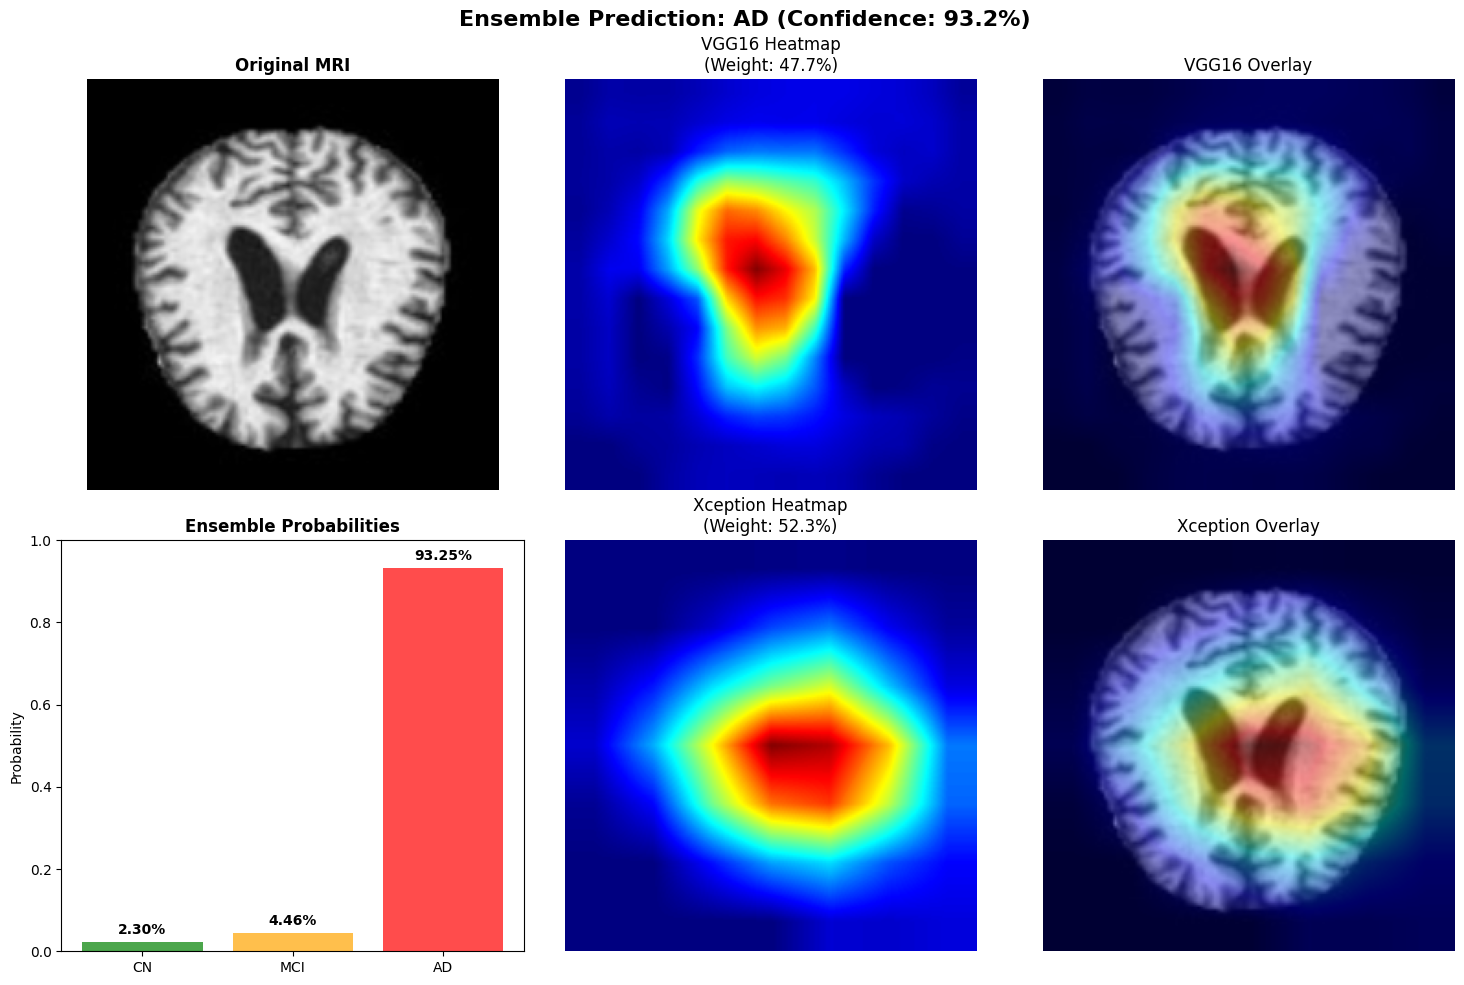

In [12]:
original_img = cv2.imread(image_path)
original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Create figure
if heatmap_xception is not None:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Ensemble Prediction: {pred_label} (Confidence: {np.max(ensemble_probs)*100:.1f}%)', 
                 fontsize=16, fontweight='bold')
    
    # Row 1: VGG16
    axes[0, 0].imshow(original_img_rgb)
    axes[0, 0].set_title('Original MRI', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(cv2.cvtColor(heatmap_vgg_colored, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(f'VGG16 Heatmap\n(Weight: {VGG_WEIGHT:.1%})', fontsize=12)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(cv2.cvtColor(overlay_vgg, cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title('VGG16 Overlay', fontsize=12)
    axes[0, 2].axis('off')
    
    # Row 2: Xception
    axes[1, 0].bar(CLASS_NAMES, ensemble_probs, color=['green', 'orange', 'red'], alpha=0.7)
    axes[1, 0].set_title('Ensemble Probabilities', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Probability')
    axes[1, 0].set_ylim([0, 1])
    for i, v in enumerate(ensemble_probs):
        axes[1, 0].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')
    
    axes[1, 1].imshow(cv2.cvtColor(heatmap_xception_colored, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title(f'Xception Heatmap\n(Weight: {XCEPTION_WEIGHT:.1%})', fontsize=12)
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(cv2.cvtColor(overlay_xception, cv2.COLOR_BGR2RGB))
    axes[1, 2].set_title('Xception Overlay', fontsize=12)
    axes[1, 2].axis('off')
    
else:
    # If Xception Grad-CAM failed, show only VGG16
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Ensemble Prediction: {pred_label} (Confidence: {np.max(ensemble_probs)*100:.1f}%)', 
                 fontsize=16, fontweight='bold')
    
    axes[0, 0].imshow(original_img_rgb)
    axes[0, 0].set_title('Original MRI', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(cv2.cvtColor(heatmap_vgg_colored, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(f'VGG16 Heatmap\n(Weight: {VGG_WEIGHT:.1%})', fontsize=12)
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(cv2.cvtColor(overlay_vgg, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title('VGG16 Overlay', fontsize=12)
    axes[1, 0].axis('off')
    
    axes[1, 1].bar(CLASS_NAMES, ensemble_probs, color=['green', 'orange', 'red'], alpha=0.7)
    axes[1, 1].set_title('Ensemble Probabilities', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Probability')
    axes[1, 1].set_ylim([0, 1])
    for i, v in enumerate(ensemble_probs):
        axes[1, 1].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('ensemble_gradcam_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'ensemble_gradcam_visualization.png'")
plt.show()


📊 Creating model comparison chart...
✅ Comparison saved as 'model_comparison.png'


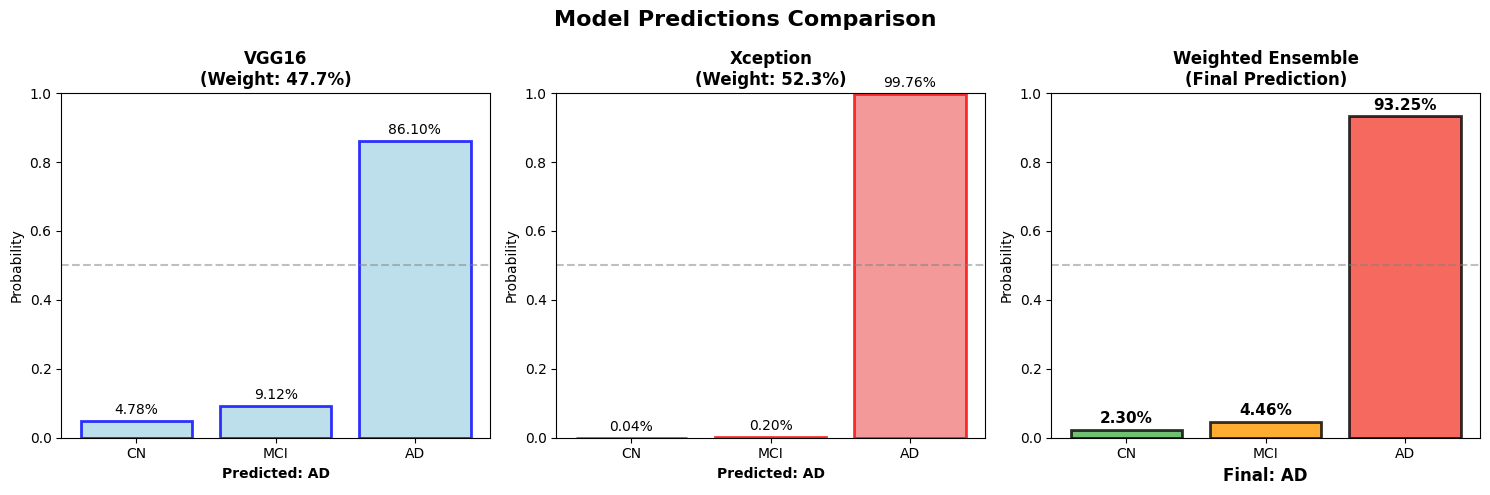


✅ Analysis complete!


In [13]:
print("\n📊 Creating model comparison chart...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Predictions Comparison', fontsize=16, fontweight='bold')

# VGG16
axes[0].bar(CLASS_NAMES, vgg_probs, color='lightblue', alpha=0.8, edgecolor='blue', linewidth=2)
axes[0].set_title(f'VGG16\n(Weight: {VGG_WEIGHT:.1%})', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Probability')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
for i, v in enumerate(vgg_probs):
    axes[0].text(i, v + 0.02, f'{v:.2%}', ha='center', fontsize=10)
axes[0].set_xlabel(f"Predicted: {CLASS_NAMES[np.argmax(vgg_probs)]}", fontweight='bold')

# Xception
axes[1].bar(CLASS_NAMES, xception_probs, color='lightcoral', alpha=0.8, edgecolor='red', linewidth=2)
axes[1].set_title(f'Xception\n(Weight: {XCEPTION_WEIGHT:.1%})', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Probability')
axes[1].set_ylim([0, 1])
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
for i, v in enumerate(xception_probs):
    axes[1].text(i, v + 0.02, f'{v:.2%}', ha='center', fontsize=10)
axes[1].set_xlabel(f"Predicted: {CLASS_NAMES[np.argmax(xception_probs)]}", fontweight='bold')

# Ensemble
axes[2].bar(CLASS_NAMES, ensemble_probs, color=['#4CAF50', '#FF9800', '#F44336'], alpha=0.8, 
            edgecolor='black', linewidth=2)
axes[2].set_title('Weighted Ensemble\n(Final Prediction)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Probability')
axes[2].set_ylim([0, 1])
axes[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
for i, v in enumerate(ensemble_probs):
    axes[2].text(i, v + 0.02, f'{v:.2%}', ha='center', fontsize=11, fontweight='bold')
axes[2].set_xlabel(f"Final: {pred_label}", fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Comparison saved as 'model_comparison.png'")
plt.show()

print("\n✅ Analysis complete!")

In [54]:
"""
As an expert, I would say:

The model primarily relies on ventricular features

It may be less sensitive to early hippocampal-only atrophy

This is expected given:

2D slices

Limited AD samples

No volumetric (3D) context
"""

'\nAs an expert, I would say:\n\nThe model primarily relies on ventricular features\n\nIt may be less sensitive to early hippocampal-only atrophy\n\nThis is expected given:\n\n2D slices\n\nLimited AD samples\n\nNo volumetric (3D) context\n'

In [55]:
import os
print(os.getcwd())


C:\Users\ferna


In [56]:
vgg16_model.save("models/vgg16.keras")
resnet50_model.save("models/resnet50.keras")


In [57]:
vgg16_model.save("ml_models/vgg16_savedmodel", save_format="tf")
resnet50_model.save("ml_models/resnet50_savedmodel", save_format="tf")


INFO:tensorflow:Assets written to: ml_models/vgg16_savedmodel\assets


INFO:tensorflow:Assets written to: ml_models/vgg16_savedmodel\assets


INFO:tensorflow:Assets written to: ml_models/resnet50_savedmodel\assets


INFO:tensorflow:Assets written to: ml_models/resnet50_savedmodel\assets


In [58]:
!zip -r resnet50_savedmodel.zip resnet50_savedmodel
!zip -r vgg16_savedmodel.zip vgg16_savedmodel

'zip' is not recognized as an internal or external command,
operable program or batch file.
'zip' is not recognized as an internal or external command,
operable program or batch file.


In [60]:
import shutil

shutil.make_archive("resnet50_savedmodel", 'zip', "ml_models/vgg16_savedmodel")
shutil.make_archive("vgg16_savedmodel", 'zip', "ml_models/vgg16_savedmodel")


'C:\\Users\\ferna\\vgg16_savedmodel.zip'

In [81]:
vgg16_model.save("ml_models/vgg16_new_savedmodel", save_format="tf")


INFO:tensorflow:Assets written to: ml_models/vgg16_new_savedmodel\assets


INFO:tensorflow:Assets written to: ml_models/vgg16_new_savedmodel\assets


In [133]:
import shutil

shutil.make_archive("xception_model_savedmodel", 'zip', "ml_models/xception_model_savedmodel")
shutil.make_archive("vgg16_new_savedmodel", 'zip', "ml_models/vgg16_new_savedmodel")

'C:\\Users\\ferna\\vgg16_new_savedmodel.zip'